# Performance Analysis of Machine Learning Software


## Correlations

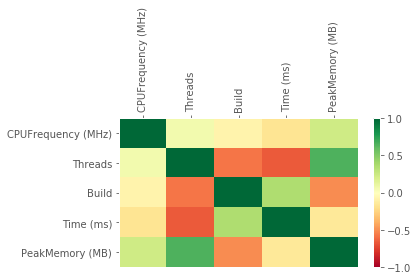

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import style 
import numpy as np
import pandas as pd
import pickle
import requests
%matplotlib inline

style.use('ggplot')

df = pd.read_csv('TestInfoAndResults.csv')
df = df.drop(df.columns[0], axis=1)

df_corr = df.corr()

data = df_corr.values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)  

heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.invert_yaxis()  
ax.xaxis.tick_top()  

column_labels = df_corr.columns
row_labels = df_corr.index

ax.set_xticklabels(column_labels)
ax.set_yticklabels(row_labels)
plt.xticks(rotation=90)
heatmap.set_clim(-1,1)  
plt.tight_layout()

plt.show()    

## Variable Correlations

- <em><b><font color='green'>Positive</font></b></em> correlation between the number of <em><b><font color='steelblue'>threads</font></b></em> and the <em><b><font color='steelblue'>peak memory</font></b></em> required.
- <em><b><font color='red'>Negative</font></b></em> correlation between the number of <em><b><font color='steelblue'>threads</font></b></em> and the <em><b><font color='steelblue'>time taken</font></b></em>.
- <em><b><font color='steelblue'>Clock speed</font></b></em> has very <em><b><font color='orange'>little impact</font></b></em> on <em><b><font color='steelblue'>time</font></b></em> and <em><b><font color='steelblue'>memory</font></b></em> performance.

# Device Comparison

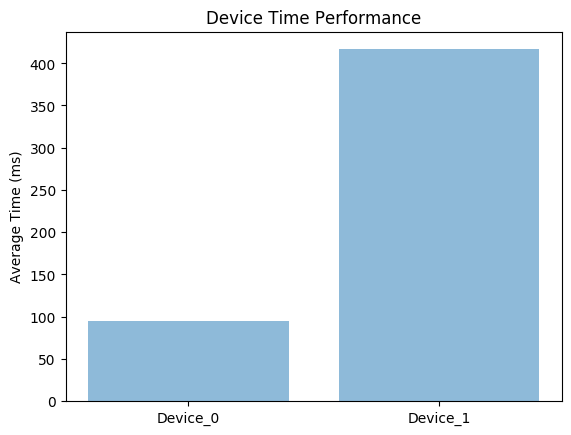

In [2]:
plt.rcdefaults()

df2 = pd.read_csv('TestInfoAndResults.csv')
df2 = df2.drop(df2.columns[0], axis=1)
df3 = df2.copy()
df2 = df2.loc[df2['Device'] == 'Device_0']
df3 = df3.loc[df3['Device'] == 'Device_1']

objects = ('Device_0', 'Device_1')
y_pos = np.arange(len(objects))
performance = [df2["Time (ms)"].mean(), df3["Time (ms)"].mean()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Time (ms)')
plt.title('Device Time Performance')

plt.show()

### Device Time Performance 

- <em><b><font color='steelblue'>Device_0</font></b></em> shows significantly <em><b><font color='green'>higher performance</font></b></em> in comparison to <em><b><font color='steelblue'>Device_1</font></b></em>.
    - <em>Note: Small amount of test data for Device_1, many not accurately represent its true performance.</em>


In [3]:
# Classifier!
csv_input = pd.read_csv('TestInfoAndResults.csv')
df4 = pd.DataFrame(csv_input)
classes = [] 

# Classify all the data using time and memory values
# These can then be used to find what values contribute most to the time/memory performance
# even if they are not numerical values.
for index, row in df4.iterrows():
    if row['Time (ms)'] > 350 and row['PeakMemory (MB)'] > 350:
        classes.append('BB') # bad bad
    elif row['Time (ms)'] <= 350 and row['Time (ms)'] > 100 and row['PeakMemory (MB)'] > 350:
        classes.append('NB') # neutral bad
    elif row['Time (ms)'] <= 100 and row['PeakMemory (MB)'] > 350:
        classes.append('GB') # good bad
    elif row['Time (ms)'] <= 350 and row['Time (ms)'] > 100 and row['PeakMemory (MB)'] <= 350 and row['PeakMemory (MB)'] > 100:
        classes.append('NN') # neutral neutral
    elif row['Time (ms)'] > 350 and row['Time (ms)'] > 100 and row['PeakMemory (MB)'] <= 350 and row['PeakMemory (MB)'] > 100:
        classes.append('BN') # bad neutral
    elif row['Time (ms)'] > 350 and row['PeakMemory (MB)'] <= 100:
        classes.append('BG') # bad good
    elif row['Time (ms)'] <= 100 and row['PeakMemory (MB)'] <= 350 and row['PeakMemory (MB)'] > 100:
        classes.append('GN') # good neutral
    elif row['Time (ms)'] > 350 and row['Time (ms)'] > 100 and row['PeakMemory (MB)'] <= 100:
        classes.append('NG') # neutral good
    elif row['Time (ms)'] <= 100 and row['PeakMemory (MB)'] <= 100:
        classes.append('GG') # good good
    else:
        print('ERROR')

    
df4['Class'] = classes
# Remove redundant / unwanted columns.
df4 = df4.drop(columns = ['TestId', 'Time (ms)', 'PeakMemory (MB)'])

In [4]:
# split the data into headers and values for the decision tree.
header = list(df4)

training_data = df4.values.tolist()

In [5]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

In [6]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in this dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [7]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [8]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Device) and a
    'column value' (e.g., Device_0). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [9]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [10]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.
    See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [11]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [12]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # Can use other operators, '>' instead of '>=' here
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [13]:
best_gain, best_question = find_best_split(training_data)

In [14]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "GB") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [15]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [16]:
def build_tree(rows):
    """Builds the tree.

    Prepare for giant stack traces :)
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # depending on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [17]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [18]:
my_tree = build_tree(training_data)

# Time and Memory Performance Classification Tree

In [19]:
print_tree(my_tree)

Is Threads >= 5?
--> True:
  Is CPUFrequency (MHz) >= 2000?
  --> True:
    Predict {'GB': 10}
  --> False:
    Is MLNetwork == MobileNet?
    --> True:
      Is Build >= 10?
      --> True:
        Predict {'GG': 1}
      --> False:
        Predict {'GB': 9}
    --> False:
      Is Build >= 6?
      --> True:
        Is Build >= 8?
        --> True:
          Is Build >= 10?
          --> True:
            Is Device == Device_1?
            --> True:
              Predict {'NB': 1}
            --> False:
              Predict {'GB': 1}
          --> False:
            Predict {'NB': 2}
        --> False:
          Predict {'GB': 2}
      --> False:
        Predict {'NB': 5}
--> False:
  Is Optimised == Y?
  --> True:
    Predict {'GG': 4}
  --> False:
    Is Threads >= 4?
    --> True:
      Predict {'NB': 3}
    --> False:
      Is Threads >= 2?
      --> True:
        Is CPUFrequency (MHz) >= 2000?
        --> True:
          Is Threads >= 3?
          --> True:
            Predict 

# Time & Memory Classification Tree

The tree above categorises the time and memory performance using the data provided.
The class '<em><b>GB</b></em>' represents a <b><em>G</em></b>ood time performance but <b><em>B</em></b>ad memory performance. The value after the classification indicates how many tests produced this result.

### Example

    Is Threads >= 5?
    --> True:
      Is CPUFrequency (MHz) >= 2000?
      --> True:
        Predict {'GB': 10}
    
This indicates that if there were 5 or more threads and the CPU Frequency was greater than or equal to 2000, then a good performance for execution time and bad for memory consumption would be observed, this is the case 10 times in the data.

### Performance Bands

   <font color='green'>- Good Performance (G)</font>
        - Time/Memory <= 100ms/100MB
   <font color='orange'>- Neutral Performance (N)</font>
        - Time/Memory > 100ms/100MB && Time/Memory <= 350ms/350MB
   <font color='red'>- Bad Performance (B)</font>
        - Time/Memory > 350ms/350MB

# Key Parameters

- <em><b><font color='steelblue'>5 threads</font></b></em> and a <em><b><font color='steelblue'>2000MHz</font></b></em> frequency produces <em><b><font color='green'>good execution times</font></b></em> but much <em><b><font color='red'> larger memory</font></b></em> usage (10 cases).

- <b><em><font color='steelblue'> Less than 5 threads</font></em></b> that are <em><b><font color='steelblue'>optimised</font></b></em>, produces <em><b><font color='green'>good time</font></b></em> and <em><b><font color='green'>good memory</font></b></em> performance (representing 4/5 cases of GG performance).

- <em><b><font color='steelblue'>1000MHz</font></b></em>, <em><b><font color='steelblue'>5 threads</font></b></em> using <em><b><font color='steelblue'>MobileNet</font></b></em> MLNetwork <b><em><font color='steelblue'>not using Build 10</font></em></b> produces <em><b><font color='green'>good execution times</font></b></em> but <em><b><font color='red'> bad memory </font></b></em>performance (9 cases).
    - If <b><em><font color='steelblue'>Build 10</font></em></b> is used, then <em><b><font color='green'>good time</font></b></em> and <em><b><font color='green'>memory</font></b></em> performance occurs (only 1 case).

- <b><em>Only 5</em></b> good <em><b><font color='green'>memory performance</font></b></em> cases are observed, <b>80%</b> from tests using <b><em><font color='steelblue'> less than 5 threads</font></b></em> that are <em><b><font color='steelblue'>optimised</font></b></em>.

# Time Performance Classification Tree

In [20]:
# Classifier 2! (Time Analysis ONLY)
csv_input2 = pd.read_csv('TestInfoAndResults.csv')
df5 = pd.DataFrame(csv_input2)
classes2 = [] 

# Classify all the data using time and memory values
for index, row in df5.iterrows():
    if row['Time (ms)'] > 350:
        classes2.append('B') # Bad
    elif row['Time (ms)'] <= 350 and row['Time (ms)'] > 100:
        classes2.append('N') # Neutral
    elif row['Time (ms)'] <= 100:
        classes2.append('G') # Good
    else:
        print('ERROR')

df5['Time Class'] = classes2
df5 = df5.drop(columns = ['TestId', 'Time (ms)', 'PeakMemory (MB)'])
header2 = list(df5)
training_data2 = df5.values.tolist()
best_gain2, best_question2 = find_best_split(training_data2)
my_tree2 = build_tree(training_data2)
print_tree(my_tree2)

Is MLNetwork == MobileNet?
--> True:
  Predict {'G': 14}
--> False:
  Is CPUFrequency (MHz) >= 2000?
  --> True:
    Is Threads >= 5?
    --> True:
      Predict {'G': 10}
    --> False:
      Is Threads >= 3?
      --> True:
        Is Threads >= 4?
        --> True:
          Predict {'N': 1}
        --> False:
          Predict {'G': 1}
      --> False:
        Predict {'N': 2}
  --> False:
    Is Threads >= 3?
    --> True:
      Is Build >= 6?
      --> True:
        Is Build >= 8?
        --> True:
          Is Threads >= 5?
          --> True:
            Is Build >= 10?
            --> True:
              Is Device == Device_1?
              --> True:
                Predict {'N': 1}
              --> False:
                Predict {'G': 1}
            --> False:
              Predict {'N': 2}
          --> False:
            Predict {'N': 4}
        --> False:
          Predict {'G': 2}
      --> False:
        Predict {'N': 5}
    --> False:
      Is Threads >= 2?
      --> T

## Time Performance Classification Tree Results

- <b><em><font color='steelblue'>MobileNet</font></em></b> in <b>100%</b> of cases gives <em><b><font color='green'>good time</font></b></em> performance (14 occurances).
- <b><em><font color='steelblue'> AlexNet</font></em></b>, <b><em><font color='steelblue'> 2000MHz</font></em></b> with <b><em><font color='steelblue'>5 threads</font></em></b> in <b>100%</b> of cases gives <em><b><font color='green'>good time</font></b></em> performance  (10 occurances).

# Memory Performance Classification Tree

In [21]:
# Classifier 3! (Memory Analysis ONLY)
csv_input3 = pd.read_csv('TestInfoAndResults.csv')
df6 = pd.DataFrame(csv_input3)
classes3 = [] 
# Classify all the data using time and memory values

for index, row in df6.iterrows():
    if row['PeakMemory (MB)'] > 350:
        classes3.append('B') # Bad
    elif row['PeakMemory (MB)'] <= 350 and row['PeakMemory (MB)'] > 100:
        classes3.append('N') # Neutral
    elif row['PeakMemory (MB)'] <= 100:
        classes3.append('G') # Good
    else:
        print(row['PeakMemory (MB)'])

df6['Memory Class'] = classes3
df6 = df6.drop(columns = ['TestId', 'Time (ms)', 'PeakMemory (MB)'])
header3 = list(df6)
training_data3 = df6.values.tolist()
best_gain3, best_question3 = find_best_split(training_data3)
my_tree3 = build_tree(training_data3)
print_tree(my_tree3)

Is Threads >= 4?
--> True:
  Is Optimised == N?
  --> True:
    Predict {'B': 29}
  --> False:
    Is Build >= 10?
    --> True:
      Predict {'G': 2}
    --> False:
      Predict {'B': 4}
--> False:
  Is Optimised == Y?
  --> True:
    Predict {'G': 3}
  --> False:
    Predict {'N': 9}


## Memory Performance Classification Tree

- Using <b><em><font color='steelblue'>4 or 5 threads</font></em></b>, <b><em><font color='steelblue'>unoptimised</font></em></b> produces <em><b><font color='red'>bad memory</font></b></em> performance in <b>100%</b> of cases (29 occurances).
- Using <b><em><font color='steelblue'>3 or less threads</font></em></b>, <b><em><font color='steelblue'> unoptimised</font></em></b> produces <em><b><font color='red'>bad memory</font></b></em> performance in <b>100%</b> of cases (9 occurances).
- Using <b><em><font color='steelblue'>3 or less threads</font></em></b>, <b><em><font color='steelblue'> optimised</font></em></b> produces <em><b><font color='green'>good memory</font></b></em> performance in <b>100%</b> of cases (only 3 occurances).


# Conclusions


The data analysis clearly shows that good performance in both execution time and peak memory usage is most frequently caused by using less than 5 threads and using optimisation techniques. Optimisation almost always produces good results in both time and memory, every test which finished in under 100ms and used under 100MB was optimised. With regards to which MLNetwork to use, MobileNet gives good execution speeds in all cases which is not the case for AlexNet. In addition to this, the top five best overall performing test cases all used MobileNetwork as well as Build 10. 

Therefore, for best results the following settings are recommended,

- Device: Device_0*
- CPU Frequency: 1000MHz**
- Threads: Less than 5 
- MLNetwork: MobileNet
- Build: 10
- Optimised: Yes

If the software is to be executed on small embedded machines where memory complexity and power consumption are limitations, then a much lower number of threads and clock speed may be favourable. If this is not the case, a greater number of threads can be utilised to improve execution speed. However, increasing the clock speed did not appear to enhance performance from the data analysed.

<em><font color='grey'>*Device_1 appears to be significantly worse with respect to execution time, but this may be totally accurate due to the small amount of test cases using Device_1.

**The impact that the clock speed has on performance is so minor that it may be more beneficial to reduce the speed in order to minimise the power consumption of the CPU.</font></em>

